# HW 05 - Taming Text

## BONUS

### Build the communication graph (unweighted and undirected) among the different email senders and recipients using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the community detection module. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

First we import the necessary modules.

In [1]:
import pandas as pd
import nltk
import pickle
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from nltk.stem import WordNetLemmatizer

%matplotlib inline
import matplotlib.pyplot as plt
import community
import networkx as nx

/home/weizhang/.local/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


### Simple example

Let's try the example from http://perso.crans.org/aynaud/communities/index.html:

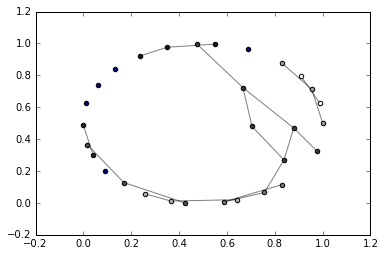

In [2]:
import matplotlib.pyplot as plt

#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G = nx.erdos_renyi_graph(30, 0.05)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

### Scouting useful info from the emails corpus

In [3]:
import pandas as pd

emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
emails.set_index(["Id"], drop=True, inplace=True)
print(emails.shape)
emails.ix[:5,:11]

(7945, 21)


,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject
Id,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,FW: Wow
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,NaN
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,Re: Chris Stevens
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,FVV: Cairo Condemnation - Final
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,NaN


In [4]:
emails.ix[:5,11:]

,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,
1,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
3,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
5,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In addition to the `Emails.csv` that we have seen in the three exercises, we have three other files containing information about the senders and receivers.

In [5]:
persons = pd.read_csv('hillary-clinton-emails/Persons.csv')
persons.set_index(["Id"], drop=True, inplace=True)
print(len(persons))
persons.head(10)

513


,Name
Id,
1,111th Congress
2,AGNA USEMB Kabul Afghanistan
3,AP
4,ASUNCION
5,Alec
6,Alex Dupuy
7,American Beverage Association
8,Andrew Mayock
9,Andrew Shapiro


`Persons.csv` contains the names of all the people and organizations that are part of the email exchanges within this corpus. A unique `Id` is assigned for each person / organization. We will use these entries as the nodes in our graph.

In [6]:
aliases = pd.read_csv('hillary-clinton-emails/Aliases.csv')
aliases.set_index(["Id"], drop=True, inplace=True)
print(len(aliases))
print(len(aliases.PersonId.unique()))
aliases.head(10)

850
513


,Alias,PersonId
Id,,
1,111th congress,1
2,agna usemb kabul afghanistan,2
3,ap,3
4,asuncion,4
5,alec,5
6,dupuy alex,6
7,american beverage association,7
8,mayock andrew,8
9,shapiro andrew j,9


`Aliases.csv` contains the different ways in which a person or organization from `Persons.csv` might appear in the email corpus. Using `unique()` we can validate that their are 513 unique `PersonId`s corresponding to the number of `Id`'s in `Persons.csv`.

In [7]:
receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')
receivers.set_index(["Id"], drop=True, inplace=True)
print(len(receivers))
print(len(receivers.EmailId.unique()))
print(len(receivers.PersonId.unique()))
receivers.head(10)

9306
7676
418


,EmailId,PersonId
Id,,
1,1,80
2,2,80
3,3,228
4,3,80
5,4,80
6,5,81
7,6,185
8,7,80
9,8,81


Out of the 7945 emails, `EmailReceivers.csv` has identified the receivers for 7676. 

Moreover, from `Emails.csv`, we can obtain the ID of the user with the column `SenderPersonId`. We can also use the column `ExtractedCc` to obtain additional users. However, mapping these entries to a person / organization in `Persons.csv` will require some extra works as we do not have the corresponding ID.

### Dictionary to map to nodes

When given an ID or Alias, we want to be able to map it to a person / organization in `Persons.csv`. For this, we will create a dictionary.

In [8]:
to_node = {}
for index, row in aliases.iterrows():
    node_id = row.PersonId
    node = persons.loc[node_id][0]
    to_node[node_id] = node
    to_node[row.Alias] = node
    
    # use "Last Name, First Name"
    names = node.split()
    if len(names) == 2:
        to_node[names[1]+", "+names[0]] = node
len(set(to_node.values()))

513

A couple manual entries for aliases that were not included in `Aliases.csv`.

In [9]:
# manual entries
to_node["H"] = 'Hillary Clinton'
to_node["Sullivan, Jacob"] = "Jake Sullivan"

### Extracting the nodes and edges

By going through each email, we will extract the author and recipients and create a DataFrame with three columns. The columns will be:

1. EmailId : corresponding to the `Id` in `Emails.csv` which is then mapped to a person with our `to_nodes` dictionary
2. Author : corresponding to the `SenderPersonId` in `Emails.csv` which is then mapped to a person with our `to_nodes` dictionary
3. Receiver(s) : obtained from `EmailReceivers.csv` and `ExtractedCc` of `Emails.csv`

The `Author` and `Receiver` will be nodes in the graph and each row will be an edge.

In [10]:
columns = ['EmailId','Author', 'Receiver']
df_graph = pd.DataFrame(columns=columns)
num_entries = 0

# go through email and extract author and recipient(s)
for email_id, row in emails.iterrows():

    # extract author
    sender_id = row.SenderPersonId
    if not pd.isnull(sender_id):
        author = to_node[sender_id]
        if author == "b6": # classified author so no use
            continue
    else:
        continue # won't be able to use it to build the graph
    
    # obtain receiver(s) for this particular ID
    recp_ids = list(receivers[receivers.EmailId==email_id].PersonId)
    recp = [to_node[p] for p in recp_ids]
    
    # extract those in CC
    cced = row.ExtractedCc
    try: # if multiple, recipients are separated by ";"
        cced = cced.split(";")
        cced = [p.lstrip(' ') for p in cced]
    except:
        cced = list([cced])
    
    # try converting those in CC to node name
    for idx in range(len(cced)):
        try:
            cced[idx] = to_node[cced[idx]]
        except:
            # perhaps of the form "<Last Name>, <First Name> <Middle Initial>" which is not in our dict
            try: # extracting just last name and first name
                full_name = cced[idx]
                last_first = " ".join(full_name.split()[:2])
                cced[idx] = to_node[last_first]
            except: pass
    
    # remove duplicates in Receiver(s) and CC
    recp_cced = list(set(recp + cced))
    
    # add entry to our new dataframe
    for receiver in recp_cced:
        if receiver == "b6": # classified receiver so no use
            continue
        df_graph.loc[num_entries] = [int(email_id), author, receiver]
        num_entries += 1

In [11]:
df_graph.dropna(inplace=True)
df_graph.head(10)

,EmailId,Author,Receiver
0,1.0,Jake Sullivan,Hillary Clinton
2,3.0,Cheryl Mills,Hillary Clinton
3,3.0,Cheryl Mills,Huma Abedin
4,4.0,Cheryl Mills,Hillary Clinton
5,4.0,Cheryl Mills,"Mitchell, Andrew B"
7,5.0,Hillary Clinton,Huma Abedin
9,6.0,Hillary Clinton,Robert Russo
10,7.0,Cheryl Mills,Hillary Clinton
13,8.0,Hillary Clinton,Huma Abedin
14,9.0,Jake Sullivan,Hillary Clinton


The `Author` entries seem fine (output suppressed below) but when we look at the `Receiver` entries, they seem to need to processing.

In [12]:
print(len(df_graph.Author.value_counts()))
# df_graph.Author.value_counts()

125


However, the `Receiver` entries need a bit of cleaning due to our decision of including `ExtractedCc`. (Output suppressed below).

In [13]:
print(len(df_graph.Receiver.value_counts()))
#df_graph.Receiver.value_counts()

1235


We see a variety of forms of "Jiloty", "Sullivan", "Mills", "Valmoro" and "Huma" which definitely seem to be the common recipients in this email corpus. Let's go ahead and fix such entries.

In [14]:
# manual edits
df_graph_clean = df_graph.copy()
count = 0
for index, row in df_graph_clean.iterrows():
    if "jiloty" in row.Receiver:
        row.Receiver = "Lauren Jiloty"
        df_graph_clean.loc[index] = row
    if "valmor" in row.Receiver:
        row.Receiver = "Lona Valmoro"
        df_graph_clean.loc[index] = row
    if "mills" in row.Receiver:
        row.Receiver = "Cheryl Mills"
        df_graph_clean.loc[index] = row
    if "sullivan" in row.Receiver:
        count += 1
        row.Receiver = "Jake Sullivan"
        df_graph_clean.loc[index] = row
    if "huma" in row.Receiver:
        count += 1
        row.Receiver = "Huma Abedin"
        df_graph_clean.loc[index] = row

In [15]:
print(len(df_graph_clean.Receiver.value_counts()))
#df_graph_clean.Receiver.value_counts()

1120


That's better but there are still some problems. Howevoer, fixing everything would be much too tedious. Let's simply remove those rows whose `Receiver` entry is not in `Persons.csv` (as these will be our nodes).

In [17]:
import numpy as np

In [18]:
df_graph_clean_nodes = df_graph_clean.copy()
nodes = set(to_node.values())
count = 0
for index, row in df_graph_clean_nodes.iterrows():
    if row.Author not in nodes:
        row.Author = np.nan
    if row.Receiver not in nodes:
        row.Receiver = np.nan
    df_graph_clean_nodes.loc[index] = row

In [19]:
df_graph_clean_nodes.dropna(inplace=True)
print("%d were dropped out of %d" % (df_graph_clean.shape[0]-df_graph_clean_nodes.shape[0], df_graph_clean.shape[0]))

2162 were dropped out of 13481


Let's save this with pickle.

In [20]:
import pickle
#pickle.dump( df_graph_clean_nodes, open( "df_graph_clean_nodes.p", "wb" ) )

In [21]:
df_graph_clean_nodes = pickle.load( open( "df_graph_clean_nodes.p", "rb" ) )
print(len(df_graph_clean_nodes))
df_graph_clean_nodes.head(15)

11319


,EmailId,Author,Receiver
1,1.0,Jake Sullivan,Hillary Clinton
2,3.0,Cheryl Mills,Hillary Clinton
3,3.0,Cheryl Mills,Huma Abedin
4,4.0,Cheryl Mills,Hillary Clinton
7,5.0,Hillary Clinton,Huma Abedin
9,6.0,Hillary Clinton,Robert Russo
11,7.0,Cheryl Mills,Hillary Clinton
13,8.0,Hillary Clinton,Huma Abedin
15,9.0,Jake Sullivan,Hillary Clinton
17,11.0,Jake Sullivan,Hillary Clinton


### Build communication graph

In [22]:
persons = set()
for email_id, row in df_graph.iterrows():
    persons.add(row.Author)
    persons.add(row.Receiver)

In [24]:
G = nx.Graph()
G.add_nodes_from(persons)

In [25]:
for email_id, row in df_graph.iterrows():
    G.add_edge(row.Author, row.Receiver)

### Partition the graph into communities

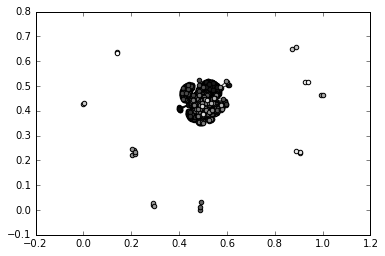

In [26]:
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [27]:
# given partition: name -> community
# build community_id -> names
community_to_persons = {}
for person, community_id in partition.items():
    if community_id not in community_to_persons:
        community_to_persons[community_id] = set()
    else:
        community_to_persons[community_id].add(person)

In [34]:
for community_id, persons in community_to_persons.items():
    print('community ' + str(community_id) + ', number of people: ' + str(len(persons)))

community 0, number of people: 37
community 1, number of people: 297
community 2, number of people: 40
community 3, number of people: 190
community 4, number of people: 57
community 5, number of people: 292
community 6, number of people: 184
community 7, number of people: 2
community 8, number of people: 18
community 9, number of people: 69
community 10, number of people: 48
community 11, number of people: 4
community 12, number of people: 2
community 13, number of people: 1
community 14, number of people: 3
community 15, number of people: 1
community 16, number of people: 1
community 17, number of people: 6
community 18, number of people: 2
community 19, number of people: 1
community 20, number of people: 1


Print the most frequent 20 words used by the email authors of each community.

### Preprocess data

In [29]:
emails_with_receivers = pd.merge(emails, receivers, how="inner", left_index=True, right_on='EmailId')

In [30]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
local_stop = {"re", "fw", "cc", "also", "pm", "am", "btw", "fyi", "to", "from", "nan"}
stop_words = stop_words | local_stop

In [31]:
def preprocess(text):
    # 1. tokenlization
    tokens = nltk.word_tokenize(text)
    
    # 2. remove tokens whose length <= 2
    tokens_not_short = [t for t in tokens if len(t) > 2]

    # 3. lowercase tokens
    tokens_lowercased = [t.lower() for t in tokens_not_short]
    
    # 4. remove tokens without a leading letter
    tokens_started_with_letter = [t for t in tokens_lowercased if t[0].isalpha()] 

    # 5. remove stop words 
    tokens_without_stop_words = [t for t in tokens_started_with_letter if t not in stop_words]
    
    # 6. stemming
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in tokens_without_stop_words]
    
    return lemmatized_tokens

### Count frequent words

In [33]:
from collections import Counter

commutity_to_freq_words = {}
for community_id, persons in community_to_persons.items():
    counter = Counter()
    for id, row in emails_with_receivers.iterrows():
        if pd.notnull(row.SenderPersonId):
            author = to_node[int(row.SenderPersonId)]
            receiver = to_node[row.PersonId]
            if (author in persons) and (receiver in persons):
                tokens = preprocess(str(row.ExtractedBodyText))
                for token in tokens:
                    counter[token] = counter[token] + 1

    print("community " + str(community_id) + ", number of people: " + str(len(people)))                
    print(counter.most_common(20))
    print()

community 0, number of people: 37
[('option', 12), ('told', 11), ('cheryl', 10), ('outlining', 10), ('amcits', 10), ('memo', 10), ('asked', 10), ('tomw', 10), ('question', 10), ('susan', 10), ("s's", 10), ('feltman', 3), ('harold', 3), ('jeffrey', 3), ('legal', 2), ('happy', 2), ('release', 2), ('please', 2), ('french', 2), ('melanne', 2)]

community 1, number of people: 297
[('state', 142), ('would', 120), ('official', 86), ('need', 78), ('time', 78), ('know', 74), ('see', 72), ('department', 71), ('u.s.', 68), ("n't", 67), ('could', 63), ('let', 63), ('call', 62), ('get', 62), ('intergovernmental', 60), ('china', 59), ('work', 59), ('national', 55), ('talk', 55), ('local', 52)]

community 2, number of people: 40
[('draft', 7), ('see', 5), ('time', 5), ('lissa', 5), ('jake', 5), ('could', 4), ('call', 4), ('good', 4), ('work', 4), ('get', 4), ('public', 3), ('day', 3), ('tomorrow', 3), ('problem', 3), ('dan', 3), ('end', 2), ('world', 2), ('anne-marie', 2), ('richard', 2), ('change', 